## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**OCO-2 GEOS Column CO₂ Concentrations**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/oco2geos-co2-daygrid-v10r_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 0.5° x 0.625°
- **Temporal extent**: January 1, 2015 - February 28, 2022
- **Temporal resolution**: Daily
- **Unit**: Parts per million
- **Utility**: Climate Research

For more, visit the [OCO-2 GEOS Column CO₂ Concentrations](https://earth.gov/ghgcenter/data-catalog/oco2geos-co2-daygrid-v10r) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the OCO-2 GEOS Column CO₂ Concentrations data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.

   

## About the Data
### OCO-2 GEOS Column CO<sub>2</sub> Concentrations

In July 2014, NASA successfully launched the first dedicated Earth remote sensing satellite to study atmospheric carbon dioxide (CO₂) from space. The Orbiting Carbon Observatory-2 (OCO-2) is an exploratory science mission designed to collect space-based global measurements of atmospheric CO₂ with the precision, resolution, and coverage needed to characterize sources and sinks (fluxes) on regional scales (≥1000 km). This dataset provides global gridded, daily column-averaged carbon dioxide (XCO₂) concentrations from January 1, 2015 - February 28, 2022. The data are derived from OCO-2 observations that were input to the Goddard Earth Observing System (GEOS) Constituent Data Assimilation System (CoDAS), a modeling and data assimilation system maintained by NASA’s Global Modeling and Assimilation Office (GMAO). Concentrations are measured in moles of carbon dioxide per mole of dry air (mol CO₂/mol dry) at a spatial resolution of 0.5° x 0.625°. Data assimilation synthesizes simulations and observations, adjusting modeled atmospheric constituents like CO₂ to reflect observed values. With the support of NASA’s Carbon Monitoring System (CMS) Program and the OCO Science Team, this dataset was produced as part of the OCO-2 mission which provides the highest quality space-based XCO₂ retrievals to date.

For more information regarding this dataset, please visit the [OCO-2 GEOS Column CO₂ Concentrations](https://earth.gov/ghgcenter/data-catalog/oco2geos-co2-daygrid-v10r) data overview page.

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. OCO-2 GEOS Column CO<sub>2</sub> Concentrations
- `item`:       One granule in the dataset, e.g. one daily file of CO<sub>2</sub> concentrations
- `asset`:      A variable available within the granule, e.g. XCO<sub>2</sub> or XCO<sub>2</sub> precision
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching metadata about available datasets
- `Raster API`: Endpoint for fetching data itself, for imagery and statistics

## Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
# For fetching from the Raster API
import requests
# For making maps
import folium
import folium.plugins
from folium import Map, TileLayer
# For talking to the STAC API
from pystac_client import Client
# For working with data
import pandas as pd
# For making time series
import matplotlib.pyplot as plt
# For formatting date/time data
import datetime
# Custom functions for working with GHGC data via the API
import ghgc_utils

## Query the STAC API
**STAC API Collection Names**

Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for the OCO-2 GEOS Column CO<sub>2</sub> Concentrations dataset is [**oco2geos-co2-daygrid-v10r**](https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r).*

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for OCO-2 GEOS Column CO₂ Concentrations. 
collection_name = "oco2geos-co2-daygrid-v10r"

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2015 to February 2022. By looking at the `dashboard:time density`, we can see that these observations are collected daily.

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=oco2geos-co2-daygrid-v10r>

In [4]:
# Check total number of items available
#items = list(collection.get_items())  # Convert the iterator to a list
#print(f"Found {len(items)} items")

In [5]:
# Examining the first item in the collection
#items[0]

In [6]:
# The search function lets you search for items within a specific date/time range
search = catalog.search(
    collections=collection_name,
    datetime=['2016-03-01T00:00:00Z','2016-07-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)

<Item id=oco2geos-co2-daygrid-v10r-20160731>
<Item id=oco2geos-co2-daygrid-v10r-20160730>
<Item id=oco2geos-co2-daygrid-v10r-20160729>
<Item id=oco2geos-co2-daygrid-v10r-20160728>
<Item id=oco2geos-co2-daygrid-v10r-20160727>
<Item id=oco2geos-co2-daygrid-v10r-20160726>
<Item id=oco2geos-co2-daygrid-v10r-20160725>
<Item id=oco2geos-co2-daygrid-v10r-20160724>
<Item id=oco2geos-co2-daygrid-v10r-20160723>
<Item id=oco2geos-co2-daygrid-v10r-20160722>
<Item id=oco2geos-co2-daygrid-v10r-20160721>
<Item id=oco2geos-co2-daygrid-v10r-20160720>
<Item id=oco2geos-co2-daygrid-v10r-20160719>
<Item id=oco2geos-co2-daygrid-v10r-20160718>
<Item id=oco2geos-co2-daygrid-v10r-20160717>
<Item id=oco2geos-co2-daygrid-v10r-20160716>
<Item id=oco2geos-co2-daygrid-v10r-20160715>
<Item id=oco2geos-co2-daygrid-v10r-20160714>
<Item id=oco2geos-co2-daygrid-v10r-20160713>
<Item id=oco2geos-co2-daygrid-v10r-20160712>
<Item id=oco2geos-co2-daygrid-v10r-20160711>
<Item id=oco2geos-co2-daygrid-v10r-20160710>
<Item id=o

In [7]:
# Restructure our items into a dictionary where keys are the datetime items
# Then we can query more easily by date/time, e.g. "2020-03-10"
items = search.item_collection()
items_dict = {item.properties["datetime"][:10]: item for item in items}

In [8]:
# Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# We'll focus on XCO2 concentrations:
asset_name = "xco2"

# Creating Maps Using Folium
In this notebook, we will explore the temporal impacts of CO₂ emissions. We will visualize the outputs on a map using `folium.`

## Fetch Imagery from Raster API
Here we get information from the `Raster API` which we will add to our map in the next section.

In [9]:
dates = ["2016-03-01","2016-07-25"]

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as the `rescale_values`, and will be passed to the Raster API in the following step(s).

In [10]:
# Extract collection name and item ID for the first date
first_date = items_dict[dates[0]]
collection_id = first_date.collection_id
item_id = first_date.id
# Select relevant asset
object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Printer raster bands' information
raster_bands

[{'scale': 1.0,
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float64',
  'histogram': {'max': 407.97830297378823,
   'min': 397.2987979068421,
   'count': 11.0,
   'buckets': [35994.0,
    21204.0,
    28584.0,
    9807.0,
    9617.0,
    29793.0,
    52299.0,
    18758.0,
    1682.0,
    198.0]},
  'statistics': {'mean': 401.71009609341064,
   'stddev': 2.678157330984702,
   'maximum': 407.97830297378823,
   'minimum': 397.2987979068421,
   'valid_percent': 0.00048091720529393656}}]

In [11]:
# Use statistics to generate an appropriate color bar range.
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

{'max': 407.97830297378823, 'min': 397.2987979068421}


Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale values` to the Raster API endpoint, along with a colormap. This step is done twice, one for each date/time you will visualize, and tells the Raster API which collection, item, and asset you want to view, specifying the colormap and colorbar ranges to use for visualization. The API returns a JSON with information about the requested image. Each image will be referred to as a tile.

In [12]:
# Choose a colormap for displaying the data
# Make sure to capitalize per Matplotlib standard colormap names
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "magma" 

In [13]:
# Make a GET request to retrieve information for the date mentioned below
tile1 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values["min"]},{rescale_values["max"]}"
).json()

# Print the properties of the retrieved granule to the console
tile1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20160301/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=397.2987979068421%2C407.97830297378823'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

In [14]:
# Repeat the above for your second date/time
# Note that we do not calculate new rescale_values for this tile
# We want date tiles 1 and 2 to have the same colorbar range for visual comparison
second_date = items_dict[dates[1]]
# Extract collection name and item ID
collection_id = second_date.collection_id
item_id = second_date.id

tile2 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values["min"]},{rescale_values["max"]}"
).json()

# Print the properties of the retrieved granule to the console
tile2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20160725/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=397.2987979068421%2C407.97830297378823'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

## Generate Map

In [15]:
# Initialize the map, specifying the center of the map and the starting zoom level.
# 'folium.plugins' allows mapping side-by-side via 'DualMap'
# Map is centered on the position specified by "location=(lat,lon)"
map_ = folium.plugins.DualMap(location=(34, -95), zoom_start=3)

# Define the first map layer (January 2020)
map_layer_1 = TileLayer(
    tiles=tile1["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    overlay=True,
    name=f"{collection.title}, {dates[0]}"
)

# Add the first layer to the Dual Map
map_layer_1.add_to(map_.m1)

# Define the second map layer (January 2000)
map_layer_2 = TileLayer(
    tiles=tile2["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer,
    overlay=True,
    name=f"{collection.title}, {dates[1]}"
)

# Add the second layer to the Dual Map
map_layer_2.add_to(map_.m2)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add colorbar
# We can use 'generate_html_colorbar' from the 'ghgc_utils' module 
# to create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(color_map,rescale_values,label=f'{items[0].assets[asset_name].title} (ppm)')

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

# Visualize the Dual Map
map_

## Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [16]:
# Give the AOI a name to use in plots later on
aoi_name = "Los Angeles Area, California"
# Create AOI polygon as a GEOJSON
aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-119.42, 34.43],
                [-119.42,33.4],
                [-117,33.4],
                [-117,34.43],
                [-119.42,34.43]            
            ]
        ],
        "type": "Polygon",
    },
}

In [17]:
# Quick Folium map to visualize this AOI
map_ = folium.Map(location=(34, -118), zoom_start=7)
# Add AOI to map
folium.GeoJson(aoi, name=aoi_name).add_to(map_)
# Add data layer to map to visualize how many grid cells lie within our AOI
map_layer_2.add_to(map_)
# Add colorbar
legend_html = ghgc_utils.generate_html_colorbar(color_map,rescale_values,label=f'{items[0].assets[asset_name].title} (ppm)')
map_.get_root().html.add_child(folium.Element(legend_html))
map_

We can generate the statistics for the AOI using a function from the `ghgc_utils` module, which fetches the data and its statistics from the Raster API.

In [43]:
%%time

# Statistics will be returned as a Pandas DataFrame
df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)
# Print the first five rows of statistics from our DataFrame
df.head(5)

Generating stats...
Done!
CPU times: user 441 ms, sys: 60.1 ms, total: 501 ms
Wall time: 44.5 s


,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2016-07-31T00:00:00+00:00,402.73201375384815037251,403.07208473677752635922,402.93507734400418485166,8.18999958038330078125,3300.03811436910700649605,0.10187300118277758942,402.95861617778427898884,402.73201375384815037251,402.73201375384815037251,15.00000000000000000000,"[[1, 1, 0, 4, 1, 0, 2, 1, 2, 3], [402.73201375...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,402.73201375384815037251,403.07208473677752635922,2016-07-31 00:00:00+00:00
1,2016-07-30T00:00:00+00:00,402.56199281429871916771,403.14309808309189975262,402.87968166898525623765,8.18999958038330078125,3299.58442381394706899300,0.18230482625803307029,402.89328171638771891594,402.56199281429871916771,402.56199281429871916771,15.00000000000000000000,"[[2, 1, 2, 0, 3, 1, 0, 2, 2, 2], [402.56199281...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,402.56199281429871916771,403.13536737812677301918,2016-07-30 00:00:00+00:00
2,2016-07-29T00:00:00+00:00,402.74460479849949479103,403.47748290514573454857,403.08157310314629739878,8.18999958038330078125,3301.23791457500874457764,0.22896203256865310660,403.08183815795928239822,402.74460479849949479103,402.74460479849949479103,15.00000000000000000000,"[[2, 3, 2, 0, 2, 2, 2, 1, 0, 1], [402.74460479...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,402.74460479849949479103,403.47748290514573454857,2016-07-29 00:00:00+00:00
3,2016-07-28T00:00:00+00:00,402.90020115207875051055,403.52593350689858198166,403.25796667511235682468,8.18999958038330078125,3302.68257785539344695280,0.18016015602694981923,403.24078145204111933708,402.90020115207875051055,402.90020115207875051055,15.00000000000000000000,"[[1, 2, 2, 0, 1, 3, 1, 3, 0, 2], [402.90020115...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,402.90020115207875051055,403.52593350689858198166,2016-07-28 00:00:00+00:00
4,2016-07-27T00:00:00+00:00,403.53622898692265152931,404.49955122312525190864,404.01733968265892826821,8.18999958038330078125,3308.90184246855415040045,0.27792947176049037639,403.96333133685402572155,403.53622898692265152931,403.53622898692265152931,15.00000000000000000000,"[[1, 3, 0, 2, 3, 1, 1, 1, 2, 1], [403.53622898...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,403.53622898692265152931,404.49955122312525190864,2016-07-27 00:00:00+00:00


## Time-Series Analysis
We can now explore the XCO₂ concentrations time series (January 1, 2015 - February 28, 2022) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

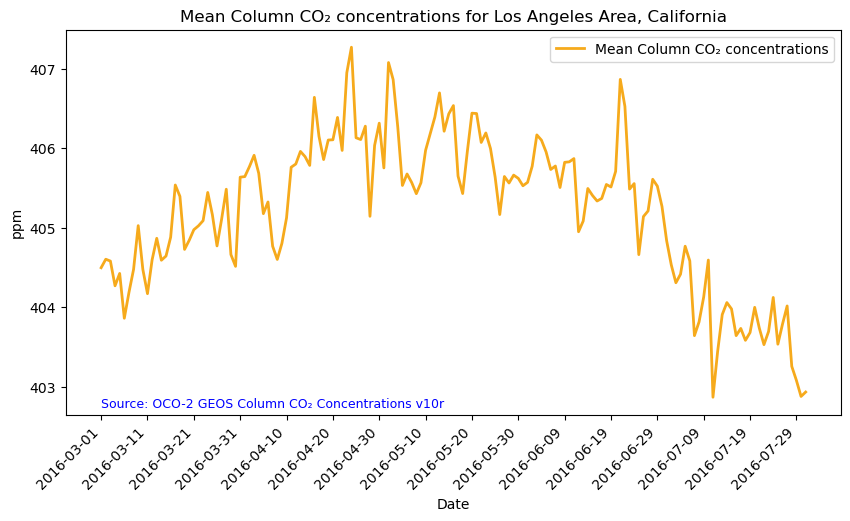

In [42]:
fig = plt.figure(figsize=(10,5))
df = df.sort_values(by="datetime")

which_stat="mean"

plt.plot(
    df["datetime"],
    df[which_stat],
    color="#F6AA1C",
    linestyle="-",
    linewidth=2,
    label=f"{which_stat.capitalize()} Column CO₂ concentrations",
)

plt.legend()
plt.xlabel("Date")
plt.ylabel("ppm")
plt.title(f"{which_stat.capitalize()} Column CO₂ concentrations for {aoi_name}")
# Format x tick frequency and labels
plt.xticks(df["datetime"][::10])
ax=plt.gca()
ax.set_xticklabels([d[0:10] for d in df["datetime"]][::10],rotation=45,ha="right")

# Add data citation
plt.text(
    min(df["datetime"]),           # X-coordinate of the text 
    df[which_stat].min(),                  # Y-coordinate of the text 
    # Text to be displayed
    f"Source: {collection.title}",                  
    fontsize=9,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

## Summary

In this notebook, we have successfully explored, analyzed, and visualized the STAC collection for OCO-2 GEOS Column CO₂ Concentrations.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the Column-Averaged XCO₂ Concentrations Levels for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).